In [16]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
import string
from spacy import displacy
import os
import pandas as pd
from spacy.tokens import Token
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statistics import mean
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
nlp.max_length = 5000000

In [9]:
added_stopwords = ['thee', 'thing', 'thy', 'ye', 'thou', 'hath']
nlp.Defaults.stop_words |= {'thee', 'thing', 'thy', 'ye', 'thou', 'hath'}

In [10]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation,
    remove words containing numbers and remove consecutive multiple white spaces.'''
    text = text.lower()
    text = re.sub('\\[.*?}''"—{\\]', '', text)
#     text = re.sub('"*', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\\w*\\d\\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' +', ' ', text)
    return text
    
def remove_stop(doc_tokens):
    """removes stop words and returns list of all nonstop words that is lemmatized"""
    return [token.lemma_ for token in doc_tokens if not token.is_stop]

def open_books(directory):
    """iterates through file and opens each txt document
        creates dictionary with keys as document name and value as document text"""
    chapter_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            chapter_dict.update({filename : open(directory + '/' + filename, errors = 'ignore').read()})
    return chapter_dict

def join_list_of_str(list_):
    """joins list of strings as one long string"""
    space = ' '
    for i in range(len(list_)):
        return space.join(list_)
    
def clean_df(df):
    """for each row in df.text, applies clean_text function"""
    for i in df.text:
        clean_text(i)
    return i

def list_of_books(df):
    list_books = []
    for i in range(len(df.text)):
        list_books.append(df.text[i])
    return list_books

def show_wordcloud(data, title = None): 
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=150,
        max_font_size=50, 
        scale=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
def compound_dict(dictionary):
    new_dict = {}
    analyzer = SentimentIntensityAnalyzer()
    for k,v in dictionary.items():
        vs = analyzer.polarity_scores(v)
        new_dict.update({k:vs['compound']})
    return new_dict

def tf_idf_dict(dict_):
    corpus = list(dict_.values())
    vectorizer = TfidfVectorizer(ngram_range = (1,2))
    X = vectorizer.fit_transform(corpus)
    idf = vectorizer.idf_
    return dict(zip(vectorizer.get_feature_names(), idf))

In [11]:
bible_dict_unclean = open_books('bible')
tanakh_dict_unclean = open_books('tanakh')
koran_dict_unclean = open_books('koran')

In [7]:
tanakh_df_unclean = pd.DataFrame.from_dict(tanakh_dict_unclean, orient = 'index', columns = ['text'])
koran_df_unclean = pd.DataFrame.from_dict(koran_dict_unclean, orient = 'index', columns = ['text'])
bible_df_unclean = pd.DataFrame.from_dict(bible_dict_unclean, orient = 'index', columns = ['text'])

In [8]:
koran_df_clean = koran_df_unclean.applymap(lambda x: clean_text(x)) 
koran_df_no_stop = koran_df_clean.applymap(lambda x: remove_stop(nlp(x)))
koran_df = koran_df_no_stop.applymap(lambda x: list(nlp(join_list_of_str(x))))

In [9]:
tanakh_df_clean = tanakh_df_unclean.applymap(lambda x: clean_text(x))
tanakh_df_no_stop = tanakh_df_clean.applymap(lambda x: remove_stop(nlp(x)))
tanakh_df = tanakh_df_no_stop.applymap(lambda x: list(nlp(join_list_of_str(x))))

In [10]:
bible_df_clean = bible_df_unclean.applymap(lambda x: clean_text(x))
bible_df_no_stop = bible_df_clean.applymap(lambda x: remove_stop(nlp(x)))
bible_df = bible_df_no_stop.applymap(lambda x: list(nlp(join_list_of_str(x))))

In [11]:
koran_dict = dict(koran_df_clean.text)
bible_dict = dict(bible_df_clean.text)
tanakh_dict = dict(tanakh_df_clean.text)

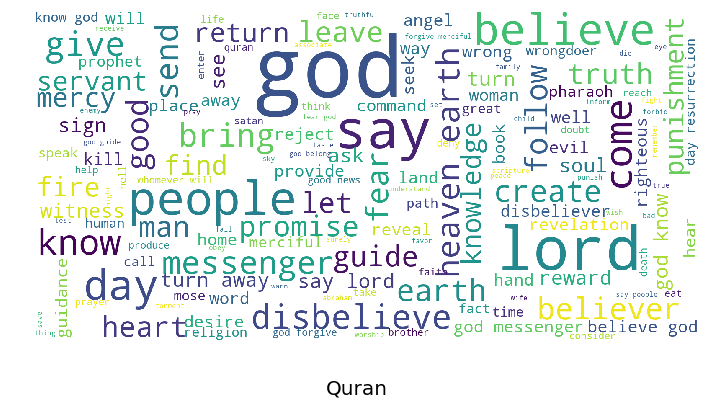

In [12]:
show_wordcloud(list_of_books(koran_df), title = 'Quran')

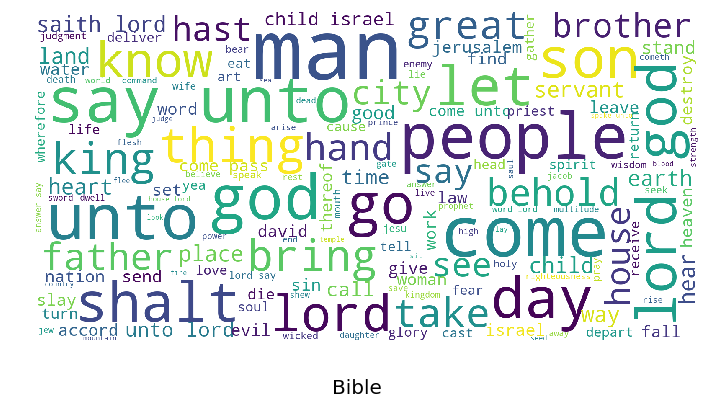

In [13]:
show_wordcloud(list_of_books(bible_df), title = 'Bible')

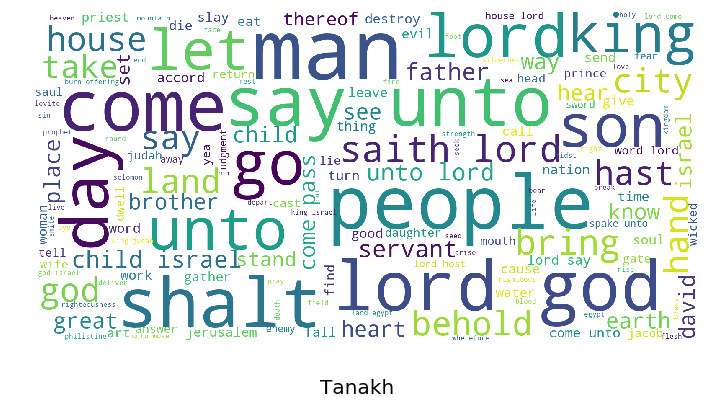

In [14]:
show_wordcloud(list_of_books(tanakh_df), title = 'Tanakh')

In [15]:
bible_list = list_of_books(bible_df)
koran_list = list_of_books(koran_df)
tanakh_list = list_of_books(tanakh_df)

In [15]:
koran_compound_dict = compound_dict(koran_dict)

In [16]:
bible_compound_dict = compound_dict(bible_dict)

In [17]:
tanakh_compound_dict = compound_dict(tanakh_dict)

In [18]:
mean(list(koran_compound_dict.values()))

0.5535605263157894

In [19]:
mean(list(bible_compound_dict.values()))

0.5117609756097561

In [20]:
mean(list(tanakh_compound_dict.values()))

0.2201076923076923

[Text(0, 0.5, 'Sentiment Value'), Text(0.5, 0, 'Books(Tanakh)')]

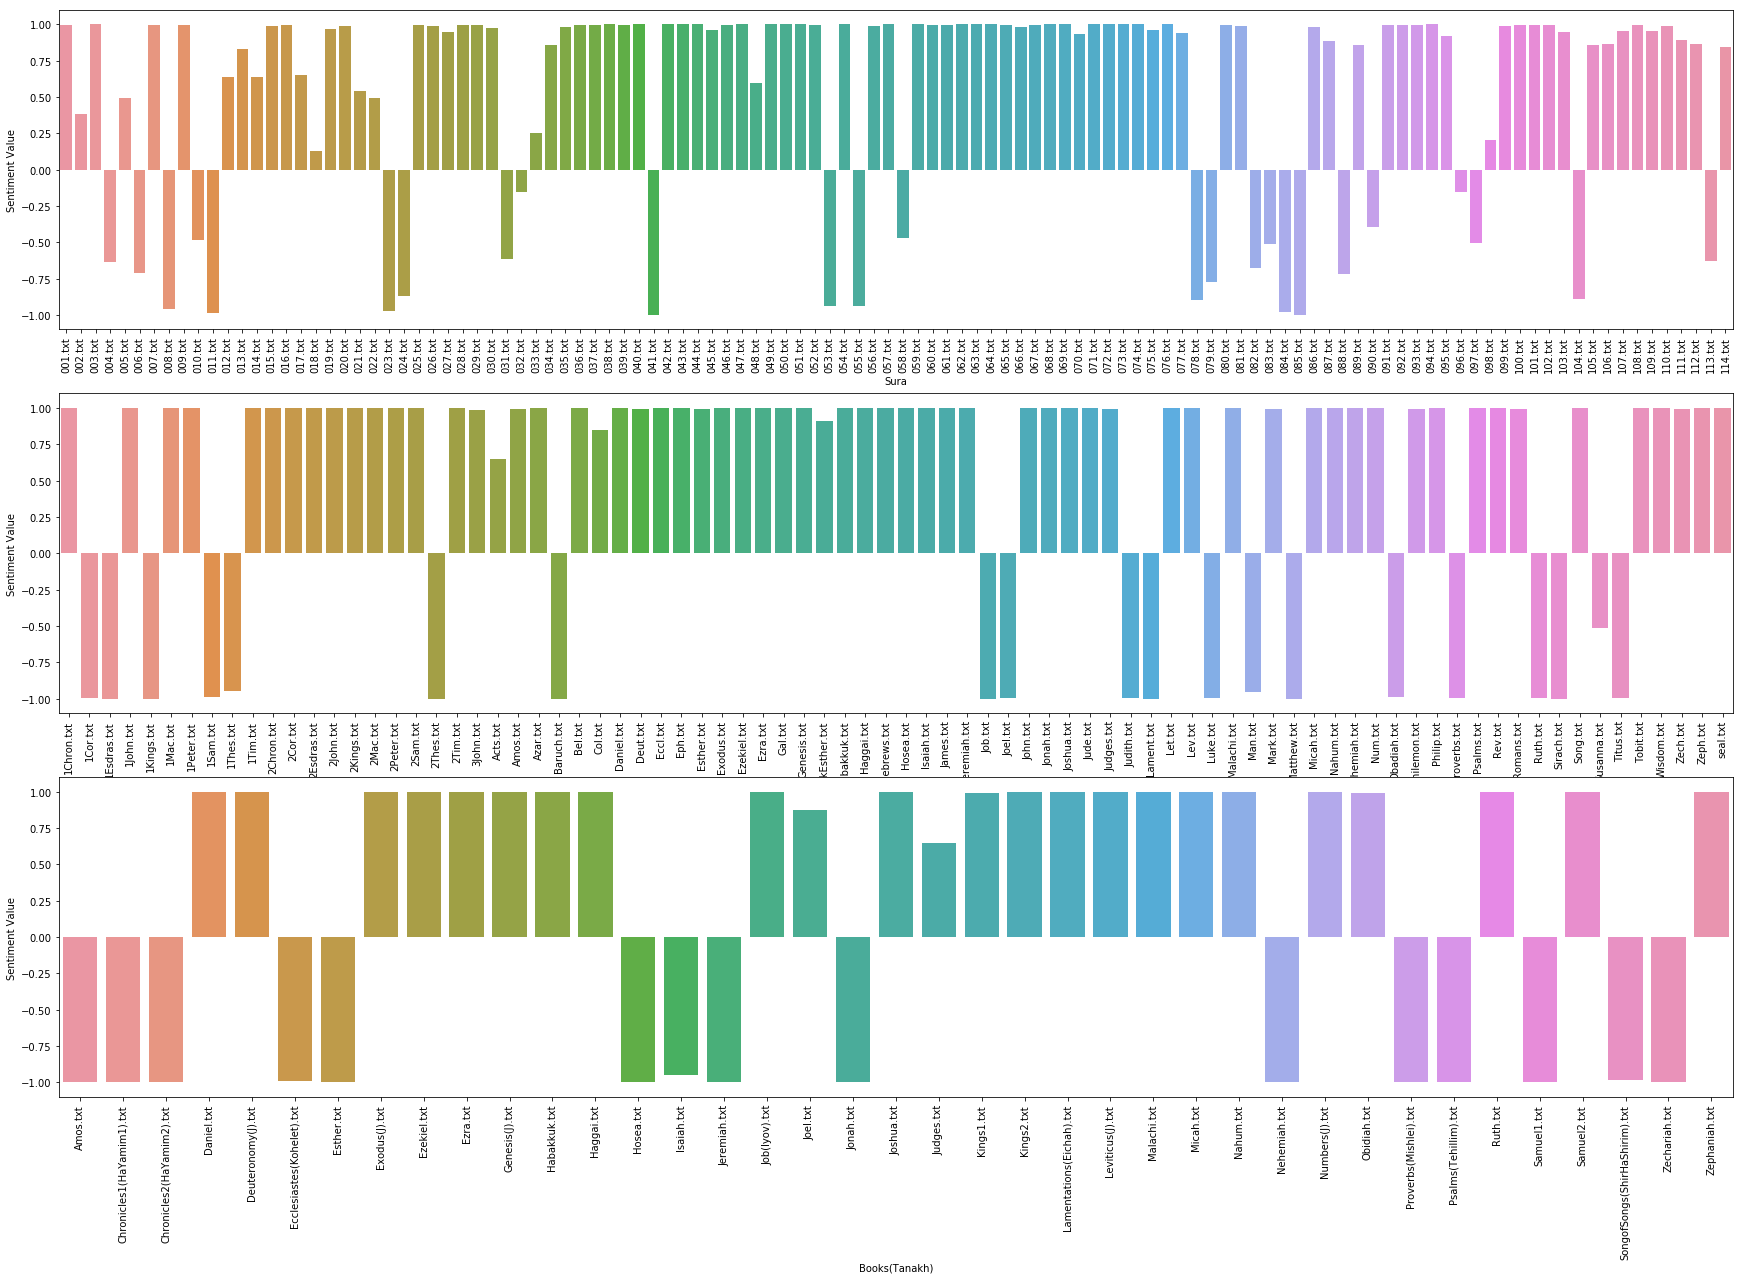

In [21]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (30,20))
# f, (ax1, ax2, ax3) = plt.subplots(1, 2, 3, figsize=(14, 4))
# plt.subplots(1, 3, sharey= True)
# fig.set_size_inches(50, 15)
a = sns.barplot(x= sorted(list(koran_compound_dict.keys())), y = list(koran_compound_dict.values()), ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=90)
ax1.set(xlabel='Sura', ylabel='Sentiment Value')

b = sns.barplot(x= sorted(list(bible_compound_dict.keys())), y = list(bible_compound_dict.values()), ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=90)
ax2.set(xlabel='Books(Bible)', ylabel='Sentiment Value')

c = sns.barplot(x= sorted(list(tanakh_compound_dict.keys())), y = list(tanakh_compound_dict.values()), ax=ax3)
plt.setp(ax3.get_xticklabels(), rotation=90)
ax3.set(xlabel='Books(Tanakh)', ylabel='Sentiment Value')

# set_xticklabels(rotation=45)


# plt.xticks(rotation='vertical')

# sns.xlim(0, 120)

# plt.figure(figsize=(15,8))

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(x, y)
# ax2.plot(x, -y)

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05
The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [22]:
koran_tf_idf = tf_idf_dict(koran_dict)
bible_tf_idf = tf_idf_dict(bible_dict)
tanakh_tf_idf = tf_idf_dict(tanakh_dict)

In [108]:
analyzer = SentimentIntensityAnalyzer()
for k,v in bible_dict.items():
    vs = analyzer.polarity_scores(v)
    print("{:-<65} {}".format(k, str(vs)))

Gal.txt---------------------------------------------------------- {'neg': 0.077, 'neu': 0.776, 'pos': 0.147, 'compound': 0.9998}
Susanna.txt------------------------------------------------------ {'neg': 0.101, 'neu': 0.819, 'pos': 0.08, 'compound': -0.9928}
Jeremiah.txt----------------------------------------------------- {'neg': 0.098, 'neu': 0.831, 'pos': 0.071, 'compound': -1.0}
2Thes.txt-------------------------------------------------------- {'neg': 0.047, 'neu': 0.806, 'pos': 0.147, 'compound': 0.9986}
Amos.txt--------------------------------------------------------- {'neg': 0.092, 'neu': 0.832, 'pos': 0.076, 'compound': -0.9981}
2Tim.txt--------------------------------------------------------- {'neg': 0.077, 'neu': 0.758, 'pos': 0.166, 'compound': 0.9995}
Joshua.txt------------------------------------------------------- {'neg': 0.034, 'neu': 0.916, 'pos': 0.05, 'compound': 0.9999}
Nahum.txt-------------------------------------------------------- {'neg': 0.118, 'neu': 0.795, 'pos

In [109]:
analyzer = SentimentIntensityAnalyzer()
for k,v in tanakh_dict.items():
    vs = analyzer.polarity_scores(v)
    print("{:-<65} {}".format(k, str(vs)))

Job(Iyov).txt---------------------------------------------------- {'neg': 0.117, 'neu': 0.776, 'pos': 0.106, 'compound': -0.9998}
Jeremiah.txt----------------------------------------------------- {'neg': 0.098, 'neu': 0.83, 'pos': 0.071, 'compound': -1.0}
Amos.txt--------------------------------------------------------- {'neg': 0.098, 'neu': 0.827, 'pos': 0.075, 'compound': -0.999}
Chronicles2(HaYamim2).txt---------------------------------------- {'neg': 0.048, 'neu': 0.865, 'pos': 0.087, 'compound': 1.0}
Joshua.txt------------------------------------------------------- {'neg': 0.034, 'neu': 0.916, 'pos': 0.05, 'compound': 0.9999}
Nahum.txt-------------------------------------------------------- {'neg': 0.12, 'neu': 0.79, 'pos': 0.089, 'compound': -0.991}
Zephaniah.txt---------------------------------------------------- {'neg': 0.117, 'neu': 0.802, 'pos': 0.081, 'compound': -0.9958}
Genesis(J).txt--------------------------------------------------- {'neg': 0.044, 'neu': 0.873, 'pos': 0.

In [107]:
analyzer = SentimentIntensityAnalyzer()
for k,v in koran_dict.items():
    vs = analyzer.polarity_scores(v)
    print("{:-<65} {}".format(k, str(vs)))

060.txt---------------------------------------------------------- {'neg': 0.063, 'neu': 0.727, 'pos': 0.21, 'compound': 0.9983}
074.txt---------------------------------------------------------- {'neg': 0.091, 'neu': 0.813, 'pos': 0.096, 'compound': 0.6954}
048.txt---------------------------------------------------------- {'neg': 0.115, 'neu': 0.66, 'pos': 0.226, 'compound': 0.9986}
114.txt---------------------------------------------------------- {'neg': 0.149, 'neu': 0.802, 'pos': 0.05, 'compound': -0.6369}
100.txt---------------------------------------------------------- {'neg': 0.065, 'neu': 0.844, 'pos': 0.092, 'compound': 0.4939}
101.txt---------------------------------------------------------- {'neg': 0.158, 'neu': 0.768, 'pos': 0.074, 'compound': -0.7572}
049.txt---------------------------------------------------------- {'neg': 0.114, 'neu': 0.655, 'pos': 0.231, 'compound': 0.9977}
075.txt---------------------------------------------------------- {'neg': 0.133, 'neu': 0.797, 'po

In [235]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(test)

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)


ValueError: Iterable over raw text documents expected, string object received.

In [233]:
test = join_list_of_str(list(koran_dict.values()))

In [236]:
test

"O you who believe! Do not take My enemies and your enemies for supporters, offering them affection, when they have disbelieved in what has come to you of the Truth. They have expelled the Messenger, and you, because you believed in God, your Lord. If you have mobilized to strive for My cause, seeking My approval, how can you secretly love them? I know what you conceal and what you reveal. Whoever among you does that has strayed from the right way.\nWhenever they encounter you, they treat you as enemies, and they stretch their hands and tongues against you with malice. They wish that you would disbelieve.\nNeither your relatives nor your children will benefit you on the Day of Resurrection. He will separate between you. God is Observant of what you do.\nYou have had an excellent example in Abraham and those with him; when they said to their people, “We are quit of you, and what you worship apart from God. We denounce you. Enmity and hatred has surfaced between us and you, forever, unti